# Setup

In [ ]:
# Install dependencies
!pip install numpy
!pip install pandas
!pip install beautifulsoup4
!pip install matplotlib

In [2]:
# Import ma libraries
import numpy as np
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup as Soup
import time

# Scrape the data

In [3]:
# Setup for scraper
releases = {'200020':'FIFA 2020', 
            '190075':'FIFA 2019',
            '180084':'FIFA 2018',
            '170099':'FIFA 2017',
            '160058':'FIFA 2016',
            '150059':'FIFA 2015',
            '140052':'FIFA 2014',
            '130034':'FIFA 2013',
            '120002':'FIFA 2012',
            '110002':'FIFA 2011',
            '100002':'FIFA 2010'}

columns = ['release','id','name','country','age','overall','potential','team','height',
           'weight','preferred_foot','best_position','value','wage']
df = pd.DataFrame(columns=columns)

In [ ]:
for release in list(releases.keys())[5:]:
    for offset in range(0,51):

        # Fetch and parse
        url = f"https://sofifa.com/players?r={str(release)}&set=true&showCol%5B%5D=pi&showCol%5B%5D=ae&showCol%5B%5D=hi&showCol%5B%5D=wi&showCol%5B%5D=pf&showCol%5B%5D=oa&showCol%5B%5D=pt&showCol%5B%5D=bp&showCol%5B%5D=vl&showCol%5B%5D=wg&col=oa&sort=desc&offset={str(offset*60)}"
        html = requests.get(url)
        soup = html.text
        data = Soup(soup,'html.parser')
        table = data.find('tbody')

        # Get all data from the table
        for i in table.find_all('tr'):    
            td = i.find_all('td')
            name = td[1].find_all('a')[1].text
            age = td[2].text.split()
            overall = td[3].find('span').text
            potential = td[4].find('span').text
            team = td[5].find('a').text
            id = td[6].text.strip()
            height = td[7].text.strip()
            weight = td[8].text.strip()
            preferred_foot = td[9].text.strip()
            best_position = td[10].text.strip()
            value = td[11].text.strip()
            wage = td[12].text.strip()

            # Put in a DataFrame and append
            data = [releases[release], id, name, country, age[0], overall, potential, team, height, 
                    weight, preferred_foot, best_position, value, wage]

            df_temp = pd.DataFrame([data])
            df_temp.columns = columns
            df = df.append(df_temp, ignore_index=True)
            
        print(releases[release] + ' - ' + str(offset) + ' out of 51')
        
# Export to CSV
df.to_csv('fifa.csv')

# Make the output pretty

In [199]:
def parse_values(value):
    value = value.replace('€','')
    indicator = value[-1]
    
    if indicator == 'M':
        value = float(value.replace('M',''))*1000000
        
    elif indicator == 'K':
        value = float(value.replace('K',''))*1000
        
    else:
        value = float(value)
    
    return value

def parse_height(height):
    height = height.replace('"','')
    feet = float(height.split("'")[0]) * 30.48
    inches = float(height.split("'")[1]) * 2.54
    return int(feet + inches)

def parse_weight(weight):
    return int(float(weight.replace('lbs','')) * 0.45359)

In [222]:
df_p = df.copy()
df_p['age'] = df_p['age'].astype(int)
df_p['overall'] = df_p['overall'].astype(int)
df_p['potential'] = df_p['potential'].astype(int)
df_p['wage'] = df_p['wage'].apply(parse_values)
df_p['value'] = df_p['value'].apply(parse_values)
df_p['height'] = df_p['height'].apply(parse_height)
df_p['weight'] = df_p['weight'].apply(parse_weight)
df_p['rank'] = df_p.sort_values(['overall','potential'],ascending=False).groupby(['release']).cumcount()+1
df_p['bmi'] = df_p['weight']/(df_p['height']/100)**2
df_p['bmi'] = df_p['bmi'].astype(int)
df_p['wage_per_point'] = df_p['wage']/df_p['overall']
df_p['value_per_point'] = df_p['value']/df_p['overall']
df_p.to_csv('fifa_parsed.csv')

# Look into it 

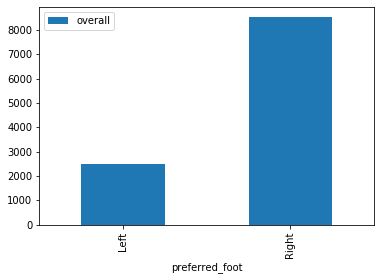

In [205]:
df_p.query('rank <= 1000').groupby('preferred_foot').overall.count().reset_index().plot.bar(x='preferred_foot',y='overall')

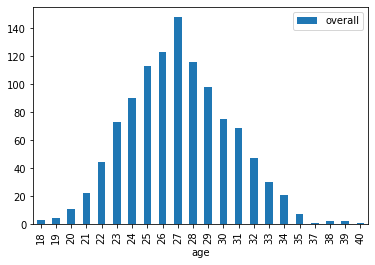

In [160]:
df_p.query('rank <= 100').groupby('age').overall.count().reset_index().plot.bar(x='age',y='overall')

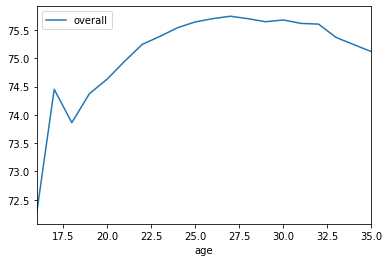

In [146]:
df_p.query('age < 36').groupby(['age']).overall.mean().reset_index().plot.line(x='age',y='overall')

In [152]:
df_p.groupby(['team','release']).overall.mean().reset_index().sort_values('overall', ascending=False)[:11]

,team,release,overall
1250,FC Bayern München,FIFA 2018,84.800000
1224,FC Barcelona,FIFA 2019,84.761905
1249,FC Bayern München,FIFA 2017,84.588235
1225,FC Barcelona,FIFA 2020,84.285714
1252,FC Bayern München,FIFA 2020,84.277778
2860,Real Madrid,FIFA 2018,84.142857
2859,Real Madrid,FIFA 2017,84.130435
1251,FC Bayern München,FIFA 2019,83.947368
2202,Manchester City,FIFA 2020,83.869565
1223,FC Barcelona,FIFA 2018,83.850000


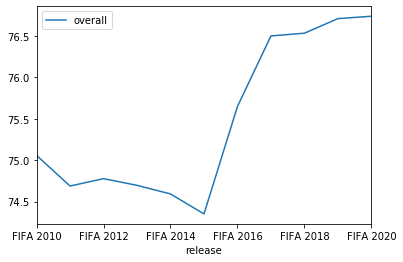

In [165]:
df_p.groupby(['release']).overall.mean().reset_index().plot.line(x='release',y='overall')

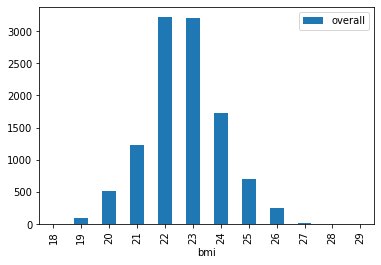

In [201]:
df_p.query('rank <= 1000').groupby('bmi').overall.count().reset_index().plot.bar(x='bmi',y='overall')

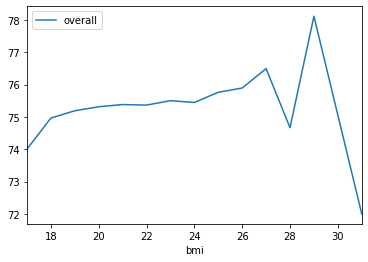

In [202]:
df_p.query('best_position != "GK"').groupby('bmi').overall.mean().reset_index().plot.line(x='bmi',y='overall')

In [223]:
df_p.query('release == "FIFA 2020"')[['name','value_per_point']].sort_values('value_per_point', ascending=False)[0:10]

,name,value_per_point
2,Neymar Jr,1.146739e+06
10,K. Mbappé,1.050562e+06
0,L. Messi,1.015957e+06
4,K. De Bruyne,9.890110e+05
5,E. Hazard,9.890110e+05
15,H. Kane,9.325843e+05
14,R. Sterling,9.269663e+05
6,M. Salah,8.944444e+05
7,V. van Dijk,8.666667e+05
3,J. Oblak,8.516484e+05


In [224]:
df_p.query('release == "FIFA 2020" & rank < 100')[['name','value_per_point']].sort_values('value_per_point', ascending=True)[0:10]


,name,value_per_point
52,Thiago Silva,212643.678161
53,Fernandinho,224137.931034
23,G. Chiellini,275280.898876
36,S. Handanovič,295454.545455
31,D. Godín,318181.818182
76,J. Vertonghen,331395.348837
73,L. Bonucci,331395.348837
44,K. Navas,350574.712644
21,Sergio Ramos,353932.584270
34,M. Neuer,363636.363636
